In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings

from dataset import *
from eval import *
from torchvision import models


device = "cuda" if torch.cuda.is_available() else "cpu"

patch_paths_20x = glob.glob("data/train_02/level0/*.jpeg")
patch_paths_10x = glob.glob("data/train_02/level1/*.jpeg")
patch_paths_2_5x = glob.glob("data/train_02/level2/*.jpeg")

In [2]:
warnings.filterwarnings("ignore")

model = models.resnet34(pretrained=True).to(device)
model = nn.Sequential(*list(model.children())[:-1])
model.eval()
pass

In [3]:
features_20x, coords_20x = extract_all_features(model, patch_paths_20x, device)
features_10x, coords_10x = extract_all_features(model, patch_paths_10x, device)
features_2_5x, coords_2_5x = extract_all_features(model, patch_paths_2_5x, device)

Extracting features: 100%|██████████| 2511/2511 [00:09<00:00, 253.61it/s]


In [4]:
labels_20x = cluster_features(features_20x)
labels_10x = cluster_features(features_10x)
labels_2_5x = cluster_features(features_2_5x)

In [5]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size=1000, num_classes=5):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
train_loader_20x = create_dataloader(features_20x, labels_20x, coords_20x)
train_loader_10x = create_dataloader(features_10x, labels_10x, coords_10x)
train_loader_2_5x = create_dataloader(features_2_5x, labels_2_5x, coords_2_5x)

In [7]:
model = MLPClassifier(input_size=features_20x.shape[1], num_classes=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_model(model, train_loader_20x, criterion, optimizer, num_epochs=50, device=device)

Epoch 1/50: 100%|██████████| 913/913 [00:00<00:00, 1225.49it/s]
2025-01-30 20:56:22,588 - INFO - Epoch 1/50 - Loss: 0.1456, Accuracy: 0.9405
Epoch 2/50: 100%|██████████| 913/913 [00:00<00:00, 1333.62it/s]
2025-01-30 20:56:23,273 - INFO - Epoch 2/50 - Loss: 0.0919, Accuracy: 0.9622
Epoch 3/50: 100%|██████████| 913/913 [00:00<00:00, 1259.34it/s]
2025-01-30 20:56:23,999 - INFO - Epoch 3/50 - Loss: 0.0803, Accuracy: 0.9680
Epoch 4/50: 100%|██████████| 913/913 [00:00<00:00, 1342.92it/s]
2025-01-30 20:56:24,680 - INFO - Epoch 4/50 - Loss: 0.0707, Accuracy: 0.9707
Epoch 5/50: 100%|██████████| 913/913 [00:00<00:00, 1382.69it/s]
2025-01-30 20:56:25,342 - INFO - Epoch 5/50 - Loss: 0.0573, Accuracy: 0.9768
Epoch 6/50: 100%|██████████| 913/913 [00:00<00:00, 1377.66it/s]
2025-01-30 20:56:26,005 - INFO - Epoch 6/50 - Loss: 0.0605, Accuracy: 0.9764
Epoch 7/50: 100%|██████████| 913/913 [00:00<00:00, 1375.58it/s]
2025-01-30 20:56:26,670 - INFO - Epoch 7/50 - Loss: 0.0533, Accuracy: 0.9789
Epoch 8/50: 1

In [8]:
evaluate_model(model, train_loader_20x, device)

Evaluating: 100%|██████████| 913/913 [00:00<00:00, 2561.09it/s]
2025-01-30 20:56:55,399 - INFO - Accuracy: 0.9917
2025-01-30 20:56:55,400 - INFO - F1 Score: 0.9916
2025-01-30 20:56:55,400 - INFO - Confusion Matrix:
2025-01-30 20:56:55,400 - INFO - 
[[5647    7  132   17   63]
 [   0 4995    0    0    0]
 [   0    0 6061    0    0]
 [   0    0   16 6700    0]
 [   0    6    2    0 5561]]


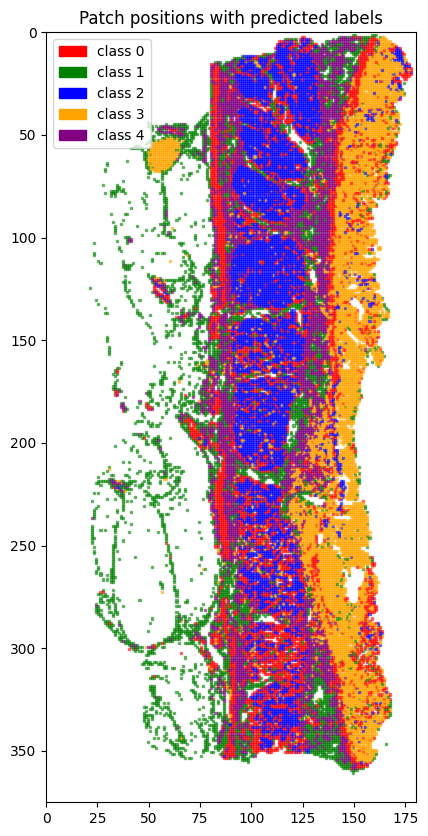

In [9]:
predicted_labels, patch_coords = get_predictions_and_coords_from_loader(model, train_loader_20x, device)
plot_patches_with_labels(patch_coords, predicted_labels)